In [7]:
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import tqdm.auto as tqdm
import time

In [2]:
class FaceDataset(data.Dataset):
    def __init__(self, path, over_sample=False):
        y, X = np.split(np.genfromtxt(path, delimiter=','), [1], axis=-1)
        y = y.squeeze()
        if over_sample:
            X, y = RandomOverSampler().fit_resample(X, y)
        X = X.reshape(-1, 1, 48, 48)
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def to(self, device):
        self.X = self.X.to(device)
        self.y = self.y.to(device)
        return self
    
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [53]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, 5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Flatten(),

            nn.Linear(24*24*256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(256, 7)
        )

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, X):
        return self.model(X)

    def predict(self, X):
        return torch.argmax(self.forward(X), dim=-1)
    
    def evaluate(self, X, y):
        model.eval()
        yhat = self.predict(X)
        yhat = yhat.detach().cpu().numpy()
        y = y.detach().cpu().numpy()
        print(f'acc: {accuracy_score(y, yhat):.5f}', end=' ')
        print(f'p: {precision_score(y, yhat, average="micro"):.5f}', end=' ')
        print(f'r: {recall_score(y, yhat, average="micro"):.5f}', end=' ')
        print(f'f1: {f1_score(y, yhat, average="micro"):.5f}', end=' ')
        print(f'P: {precision_score(y, yhat, average="macro"):.5f}', end=' ')
        print(f'R: {recall_score(y, yhat, average="macro"):.5f}', end=' ')
        print(f'F1: {f1_score(y, yhat, average="macro"):.5f}')
#         print(f'accuracy: {accuracy_score(y, yhat):.5f}')
#         print(f'precision (micro): {precision_score(y, yhat, average="micro"):.5f}')
#         print(f'recall (micro): {recall_score(y, yhat, average="micro"):.5f}')
#         print(f'f1 (micro): {f1_score(y, yhat, average="micro"):.5f}')
#         print(f'precision (macro): {precision_score(y, yhat, average="macro"):.5f}')
#         print(f'recall (macro): {recall_score(y, yhat, average="macro"):.5f}')
#         print(f'f1 (macro): {f1_score(y, yhat, average="macro"):.5f}')

In [64]:
def train(model, opt, train_loader, n_epochs, test_loader=None):
    losses = []
    for epoch in tqdm.tqdm(range(n_epochs)):
        model.train()
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            yhat = model(X)
            loss = model.criterion(yhat, y)
            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            losses.append(loss.item())
        
        if test_loader is not None:
            print(f'#{epoch+1}:- ', end='')
            model.eval()
            true = []
            pred = []
            for X, y in test_loader:
                X = X.to(device)
                y = y.to(device)
                yhat = model.predict(X)
                true.extend(y.cpu().tolist())
                pred.extend(yhat.cpu().tolist())
            print(f'acc: {accuracy_score(true, pred):.5f}', end=' ')
            print(f'p: {precision_score(true, pred, average="micro"):.5f}', end=' ')
            print(f'r: {recall_score(true, pred, average="micro"):.5f}', end=' ')
            print(f'f1: {f1_score(true, pred, average="micro"):.5f}', end=' ')
            print(f'P: {precision_score(true, pred, average="macro"):.5f}', end=' ')
            print(f'R: {recall_score(true, pred, average="macro"):.5f}', end=' ')
            print(f'F1: {f1_score(true, pred, average="macro"):.5f}', flush=True)

    return losses

In [65]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device:', device)

device: cuda


In [66]:
#train_set = FaceDataset('train.csv', over_sample=True)#.to(device)

In [67]:
#test_set = FaceDataset('public_test.csv')#.to(device)

In [68]:
model = Model().to(device)

In [69]:
opt = optim.Adam(model.parameters(), lr=1e-3)
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=True, num_workers=4)

In [70]:
train_losses = train(model, opt, train_loader, 4, test_loader)

#1:- acc: 0.44976 p: 0.44976 r: 0.44976 f1: 0.44976 P: 0.39607 R: 0.44411 F1: 0.40430
#2:- acc: 0.49760 p: 0.49760 r: 0.49760 f1: 0.49760 P: 0.47281 R: 0.48400 F1: 0.47580
#3:- acc: 0.51959 p: 0.51959 r: 0.51959 f1: 0.51959 P: 0.49989 R: 0.48500 F1: 0.48773
#4:- acc: 0.53058 p: 0.53058 r: 0.53058 f1: 0.53058 P: 0.52487 R: 0.50350 F1: 0.51144



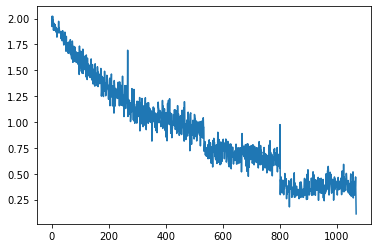

In [71]:
plt.plot(train_losses)
plt.show()

In [51]:
model.evaluate(test_set.X, test_set.y)

RuntimeError: CUDA out of memory. Tried to allocate 3.55 GiB (GPU 0; 31.75 GiB total capacity; 510.13 MiB already allocated; 332.50 MiB free; 3.93 GiB reserved in total by PyTorch)

In [50]:
torch.cuda.empty_cache()